In [1]:
import numpy as np
from numpy import radians
from lib.cartpolesystem import CartPoleSystem, Cart, Pole, DCMotor
from lib.cartpoleenv import CartPoleEnv
from lib.direct_collocation import DirectCollocation
from lib.controllers import LQR
from time import perf_counter
from matplotlib import pyplot as plt
from lib.numerical import rk4_step

ModuleNotFoundError: No module named 'lib.cartpolesystem_new'

In [ ]:
dt = 0.01
g = 9.81

cart = Cart(1, 0.01, (-0.8, 0.8), 0.25)
motor = DCMotor(0.2, 0.2, 0.2, 0.05, 8.7e-5, 8.7e-5, (-24, 24), 0.1, (-100, 100), 0.1)
poles = [Pole(1, 0.2, 0.1), Pole(1, 0.3, 0.1)]
n = len(poles)

system = CartPoleSystem(cart, motor, poles, g)

max_time = 10
N_env = int(max_time/dt)

env = CartPoleEnv(system, dt, N_env, rk4_step)
env.observation_space.shape

c:\Users\sacka\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


(6,)

Optimizing trajectory...
{'variables': 98978, 'objective': 32953, 'eq_constraints': 33012, 'ineq_constraints': 33012, 'variables_mean': 2.204285862860845e-06, 'variables_total': 0.2181758061342407, 'objective_mean': 4.934889103388249e-06, 'objective_total': 0.16261940062395297, 'eq_constraints_mean': 0.00397385239305911, 'eq_constraints_total': 131.18481519966736, 'ineq_constraints_mean': 0.0012023179238025684, 'ineq_constraints_total': 39.690919300570386}


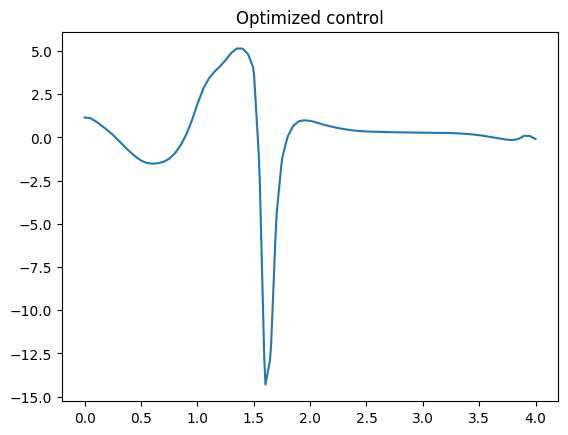

In [ ]:
end_time = 4
dt_collocation = 0.05
N_collocation = int(end_time/dt_collocation)+1

N = int(end_time/dt)

direct_collocation = DirectCollocation(
    N_collocation,
    system.differentiate, 
    system.state_lower_bound.shape[0],
    system.control_lower_bound.shape[0],
    system.constraints,
    system.calculate_error,
    0.001
)

x0 = np.array([0, 0] + [radians(180), 0]*n)

r = np.array([0.1, 0] + [0, 0]*n)

last_update = perf_counter()

print("Optimizing trajectory...")
states, controls = direct_collocation.make_controller(end_time, x0, r, N)

time = np.linspace(0, end_time, N)

plt.title("Optimized control")
plt.plot(time, controls.T[0])
plt.show()

In [ ]:
np.set_printoptions(precision=1)

linearization_x0 = np.zeros(2+2*n)
linearization_u0 = np.array([0])

A0, B0 = system.linearize(linearization_x0, linearization_u0)

C = np.zeros((1+n, 2+2*n))
C[0,0] = 1
for i in range(n):
    C[i+1, 2+2*i] = 1

D = np.zeros((1, 1))

ct_dt = dt

lqr = LQR(ct_dt)

Q = np.diag([50, 1]+[100, 10]*n)
R = np.diag([100])

A_d0, B_d0 = lqr.discretize(A0, B0, C, D)
K_d0 = lqr.calculate_K_d(A_d0, B_d0, Q, R)

# A_aug0, B_aug0 = lqr.error_augment(A0, B0, C)
# A_aug_d0, B_aug_d0 = lqr.discretize(A_aug0, B_aug0, C, D)

# Q_aug = np.concatenate((np.concatenate((Q, np.zeros(C.shape))), np.concatenate((np.zeros(C.T.shape), np.diag([1000]*(n+1))))), axis=1)

# def is_controllable(A, B):
#     n = A.shape[0]  # Number of states
#     controllability_matrix = np.column_stack([np.linalg.matrix_power(A, i) @ B for i in range(n)])
#     rank = np.linalg.matrix_rank(controllability_matrix)
#     print("n", n)
#     print("rank", rank)
#     return rank == n

# if is_controllable(A_aug_d0, B_aug_d0):
#     print("The system is controllable.")
# else:
#     print("The system is not controllable.")

# _, K_aug_d0 = lqr.calculate_K_d(A_aug_d0, B_aug_d0, Q_aug, R)
# print("K_aug_d0:", K_aug_d0.shape)

In [ ]:
print("Calculating As and Bs...")
As, Bs = np.vectorize(system.linearize, signature='(n),(m)->(n,n),(n,m)')(states, controls)
print("Calculating A_ds and B_ds...")
A_ds, B_ds = np.vectorize(lqr.discretize, signature='(n,n),(n,m),(a,b),(c,d)->(n,n),(n,m)')(As, Bs, C, D)

# print("Calculating A_augs and B_augs...")
# A_augs, B_augs = np.vectorize(lqr.error_augment, signature='(n,n),(n,m),(k,n)->(o,o),(o,p)')(As, Bs, C)
# print("Calculating A_aug_ds and B_aug_ds...")
# A_aug_ds, B_aug_ds = np.vectorize(lqr.discretize, signature='(n,n),(n,m),(a,b),(c,d)->(n,n),(n,m)')(A_augs, B_augs, C, D)

print("Calculating K_ds...")
_, K_ds = lqr.calculate_finite_K_ds(A_ds, B_ds, Q, R)
# print("Calculating K_aug_ds...")
# _, K_aug_ds = lqr.calculate_finite_K_ds(A_aug_ds, B_aug_ds, Q_aug, R)

Calculating As and Bs...
Calculating A_ds and B_ds...
Calculating K_ds...


In [ ]:
print("Memory usage K_ds: ", (K_ds.nbytes)/1024**1, "KB")
# print("Memory usage K_aug_ds: ", (K_aug_ds.nbytes)/1024**1, "KB")

Memory usage K_ds:  18.75 KB


In [ ]:
last_update = perf_counter()
state, _ = env.reset(x0)

errors = np.zeros((N_env, 2+2*n))
# acc_error = np.zeros((1))

for i in range(N_env-1):
    while perf_counter() < last_update + dt:
        pass
    last_update = perf_counter()

    error = np.zeros(2+2*n)
    if i < N*1:
        error = system.calculate_error(state, states[i])
        u_ff = controls[i]
        # acc_error = (error @ C.T) + acc_error
        # state_error = np.concatenate((error, acc_error))
        u_fb = lqr.feedback(K_ds[i], error)
        u = u_ff + u_fb
    else:
        error = system.calculate_error(state, states[-1])
        u = lqr.feedback(K_ds[-1], error)
    errors[i] = error

    state, reward, done, msg, _ = env.step(u)
    env.render()

env.close()

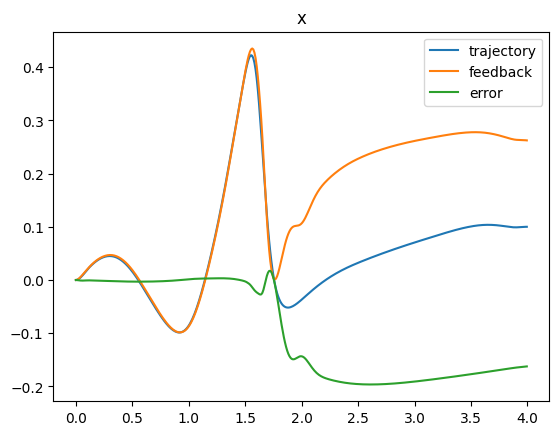

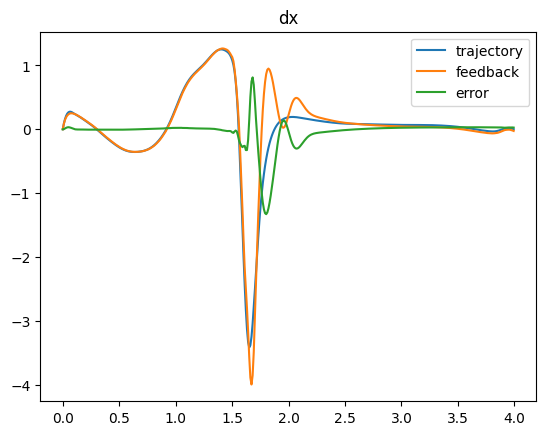

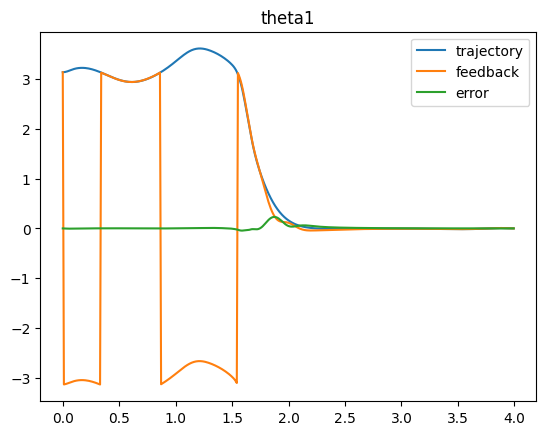

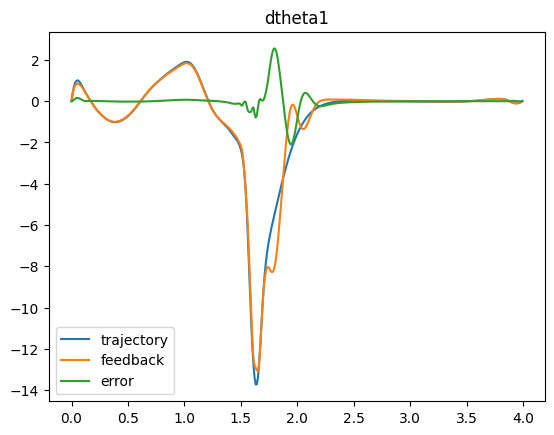

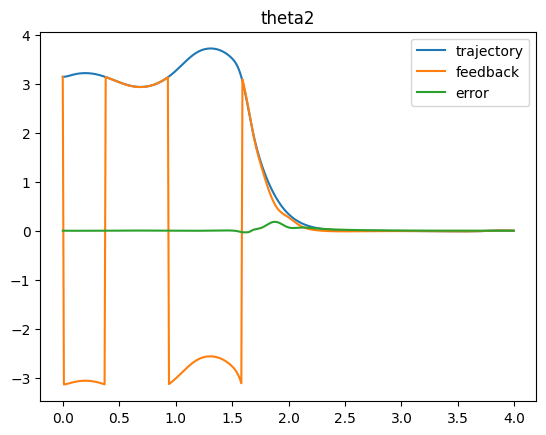

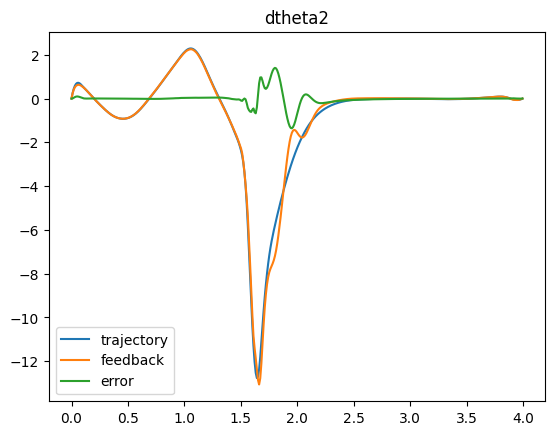

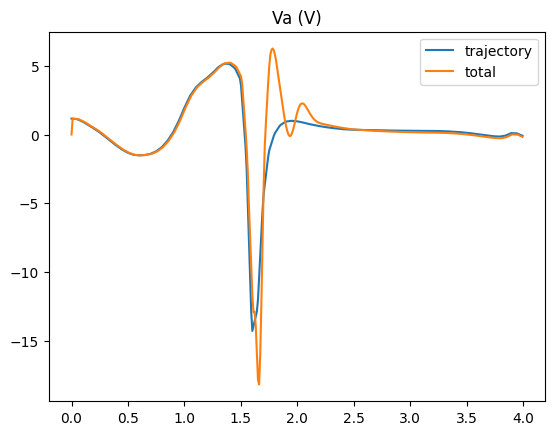

In [ ]:
time = np.linspace(0, max_time, N_env)
labels = ["x", "dx", "theta1", "dtheta1", "theta2", "dtheta2"]
for i in range(2+2*n):
    plt.title(labels[i])
    plt.plot(time[:N], states.T[i][:N], label="trajectory")
    plt.plot(time[:N], env.states.T[i][:N], label="feedback")
    plt.plot(time[:N], errors.T[i][:N], label="error")
    plt.legend()
    plt.show()
plt.title("Va (V)")
plt.plot(time[:N], controls.T[0][:N], label="trajectory")
plt.plot(time[:N], env.controls.T[0][:N], label="total")
plt.legend()
plt.show()